In [3]:
import sys, os
import numpy as np

sys.path.append(os.path.abspath('./'))
from pysplendor.game import Trajectory, traj_loader
from pysplendor.splendor import SplendorGameState, CARD_LEVELS, Action, CHANCE_PLAYER
from prepare_data import SplendorGameStateEncoder, ACTION_ID
import matplotlib.pyplot as plt

In [ ]:
traj_file = os.path.abspath('./data/traj_dump_1k.txt')
state_encoder = SplendorGameStateEncoder(2)
STATE_LEN = 1052
NUM_ACTIONS = 43

state_bit_counts = np.zeros(shape=(STATE_LEN,))
action_counts = [0] * NUM_ACTIONS

num_states = 0
for traj in traj_loader(traj_file):
    state = traj.initial_state.copy()
    for action in traj.actions:
        if state.active_player() != CHANCE_PLAYER: # ignore chance nodes
            state_vec = state_encoder.state_to_vec(state)
            state_bit_counts += np.array(state_vec)
            num_states += 1
            action_counts[ACTION_ID.get(str(action))] += 1

        state.apply_action(action)


In [ ]:
print(f'num states: {num_states}')
print(f'sum action counts: {sum(action_counts)}')
for action, n in ACTION_ID.items():
    print(f'{action}: {action_counts[n]} {action_counts[n] / num_states * 100:.2f}%')

probs = [action_counts[n] / num_states for n in range(len(ACTION_ID))]
print(','.join([f'{p:.4f}' for p in probs]))

num states: 58588
sum action counts: 58588
s: 199 0.34%
tr2: 373 0.64%
tg2: 226 0.39%
tb2: 196 0.33%
tw2: 256 0.44%
tk2: 245 0.42%
tr1g1b1: 1719 2.93%
tr1g1w1: 1927 3.29%
tr1g1k1: 2060 3.52%
tr1b1w1: 1936 3.30%
tr1b1k1: 1917 3.27%
tr1w1k1: 2170 3.70%
tg1b1w1: 1402 2.39%
tg1b1k1: 1377 2.35%
tg1w1k1: 1670 2.85%
tb1w1k1: 1674 2.86%
r0n0: 1257 2.15%
r0n1: 1105 1.89%
r0n2: 1256 2.14%
r0n3: 1287 2.20%
r1n0: 799 1.36%
r1n1: 784 1.34%
r1n2: 879 1.50%
r1n3: 982 1.68%
r2n0: 592 1.01%
r2n1: 600 1.02%
r2n2: 633 1.08%
r2n3: 836 1.43%
p0n0: 3002 5.12%
p0n1: 3351 5.72%
p0n2: 3791 6.47%
p0n3: 4959 8.46%
p1n0: 1392 2.38%
p1n1: 1392 2.38%
p1n2: 1465 2.50%
p1n3: 1672 2.85%
p2n0: 274 0.47%
p2n1: 336 0.57%
p2n2: 346 0.59%
p2n3: 399 0.68%
h0: 2369 4.04%
h1: 2078 3.55%
h2: 1405 2.40%
0.0034,0.0064,0.0039,0.0033,0.0044,0.0042,0.0293,0.0329,0.0352,0.0330,0.0327,0.0370,0.0239,0.0235,0.0285,0.0286,0.0215,0.0189,0.0214,0.0220,0.0136,0.0134,0.0150,0.0168,0.0101,0.0102,0.0108,0.0143,0.0512,0.0572,0.0647,0.0846,0.02

In [ ]:
num_nonzero = sum([1 for x in state_bit_counts if x > 0])
print(f'nonzero bits: {num_nonzero} of {STATE_LEN}')
print('percentage of 1-s in each state position')
for n, freq in enumerate(state_bit_counts):
    if freq > 0:
        print(f'{n}: {freq / num_states * 100:.2f}%')
# print(state_bit_counts)

nonzero bits: 754 of 1052
percentage of 1-s in each state position
0: 98.63%
4: 1.26%
7: 0.83%
8: 99.07%
11: 0.83%
12: 99.07%
15: 0.83%
16: 99.90%
20: 99.90%
30: 91.29%
34: 6.90%
37: 91.29%
38: 6.90%
41: 91.29%
42: 6.90%
45: 91.29%
46: 98.19%
50: 98.19%
64: 90.85%
68: 90.85%
72: 90.85%
76: 90.85%
80: 90.85%
90: 11.11%
91: 10.38%
92: 24.88%
93: 14.08%
94: 39.56%
96: 90.90%
97: 9.10%
102: 45.06%
103: 32.01%
104: 10.33%
105: 10.45%
106: 37.94%
107: 33.69%
108: 22.84%
109: 4.26%
110: 55.44%
111: 13.68%
112: 25.50%
113: 2.91%
114: 50.03%
115: 29.52%
116: 12.52%
117: 6.57%
118: 48.80%
119: 22.95%
120: 21.16%
121: 5.23%
122: 100.00%
132: 15.73%
133: 14.81%
134: 15.79%
135: 19.56%
136: 34.12%
138: 86.74%
139: 13.26%
144: 42.50%
145: 31.15%
146: 15.32%
147: 8.03%
148: 49.45%
149: 31.19%
150: 11.62%
151: 5.54%
152: 50.30%
153: 19.93%
154: 22.32%
155: 4.15%
156: 45.67%
157: 29.92%
158: 14.79%
159: 7.45%
160: 55.41%
161: 26.41%
162: 9.61%
163: 5.97%
164: 100.00%
174: 18.60%
175: 18.43%
176: 19.15%

In [ ]:
# look at model predictions for a particular trajectory
import torch
from train import TwoHeadMLP
from prepare_data import SplendorGameStateEncoder, ALL_ACTIONS

def model_predict(model, state_encoder, state, K=5):
    '''Retruns top K predicted actions and qvalue'''
    state_vec = state_encoder.state_to_vec(state)
    X = torch.tensor(state_vec, dtype=torch.float32)
    logits, qval = model.forward(X)
    top_actions = np.argsort(logits.detach().numpy())[-K:]
    logits = logits[top_actions]
    return top_actions, logits, qval.item()

def run_model():
    '''Aloows to inspect the moves predicted by the model'''
    state_encoder = SplendorGameStateEncoder(2)
    STATE_LEN = 1052
    NUM_ACTIONS = 43

    model = TwoHeadMLP(STATE_LEN, 50, NUM_ACTIONS)
    model_path = './data/models/mlp_0.pth'
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.eval()

    traj_file = './data/traj_dump_10k.txt'
    loader = traj_loader(traj_file)
    for _ in range(1100):
        next(loader)
    traj = next(loader) # pick one
    state = traj.initial_state.copy()
    rewards = traj.rewards

    for action in traj.actions:
        if state.active_player() != CHANCE_PLAYER: # ignore chance nodes
            top_actions, logits, qval = model_predict(model, state_encoder, state, K=5)
            print(state)
            suggested_actions = ' '.join([f'{ALL_ACTIONS[a]} ({l:.2f})' for a, l in zip(top_actions, logits)])
            print(f'predicted actions: {suggested_actions} qval: {qval:.3f} reward: {rewards[state.active_player()]}')
            print(f'actual action: {action}\n')

        state.apply_action(action)

run_model()

Traceback (most recent call last):
  File "/Users/seal/.vscode/extensions/ms-python.python-2025.2.0-darwin-arm64/python_files/python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
  File "<string>", line 7, in <module>
  File "/opt/homebrew/lib/python3.10/site-packages/torch/serialization.py", line 1471, in load
    return _load(
  File "/opt/homebrew/lib/python3.10/site-packages/torch/serialization.py", line 1964, in _load
    result = unpickler.load()
  File "/opt/homebrew/lib/python3.10/site-packages/torch/serialization.py", line 1953, in find_class
    return super().find_class(mod_name, name)
AttributeError: Can't get attribute 'TwoHeadMLP' on <module '__main__' from '/Users/seal/.vscode/extensions/ms-python.python-2025.2.0-darwin-arm64/python_files/python_server.py'>



In [ ]:
from pysplendor.agents import MCTSAgent, MCTS
# from prepare_data import ACTION_ID

def print_root_visits(mcts: MCTS):
    children_dict = {str(child.action): child for child in mcts.root.children}
    for action in ALL_ACTIONS:
        if action in children_dict:
            child = children_dict[action]
            print(f'{child.action}:\t{child.visits}')

    # children = sorted(mcts.root.children, key=lambda x: x.visits)
    # for child in children:
    #     print(f'{child.action}: {child.visits}')

def compare_mcts_variants():
    traj_file = './data/traj_dump.txt'
    loader = traj_loader(traj_file)
    # for _ in range(1100):
    #     next(loader)
    traj = next(loader) # pick one
    state = traj.initial_state.copy()
    rewards = traj.rewards

    for action in traj.actions:
        if state.active_player() != CHANCE_PLAYER: # ignore chance nodes
            print(state)
            agent1 = MCTS(state, iterations = 1000)
            agent2 = MCTS(state, iterations = 1500)

            action1 = agent1.search()
            action2 = agent2.search()

            print(f'action1: {action1} action2: {action2} actual action: {action}\n')
            print('\nagent1:')
            print_root_visits(agent1)
            print('\nagent2:')
            print_root_visits(agent2)

        state.apply_action(action)




Traceback (most recent call last):
  File "/Users/seal/.vscode/extensions/ms-python.python-2025.2.0-darwin-arm64/python_files/python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
  File "<string>", line 1, in <module>
  File "/Users/seal/projects/splendor/pysplendor/agents.py", line 5, in <module>
    from .mcts import MCTS
  File "/Users/seal/projects/splendor/pysplendor/mcts.py", line 5, in <module>
    from .game_state import GameState, CHANCE_PLAYER
ImportError: cannot import name 'CHANCE_PLAYER' from 'pysplendor.game_state' (/Users/seal/projects/splendor/pysplendor/game_state.py)



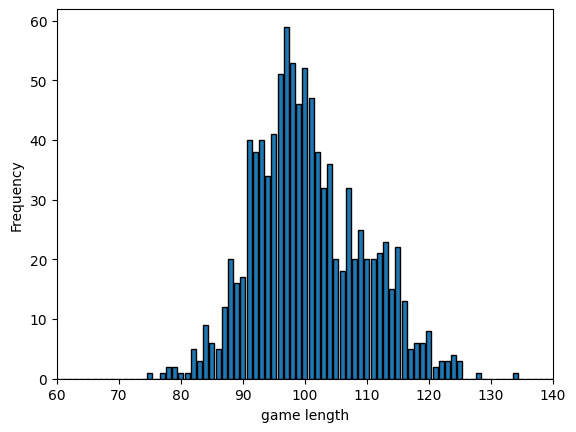

In [11]:
traj_file = os.path.abspath('./data/traj_dump_1k_cpw.txt')

max_len = 150
game_lens = [0] * max_len
for traj in traj_loader(traj_file):
    game_lens[len(traj.actions)] += 1

plt.bar(range(max_len), game_lens, edgecolor='black')

plt.xlabel('game length')
plt.ylabel('Frequency')
plt.xlim(60, 140)
plt.show()


